# Video analysis

## Table of contents
- [Camera calibration](#Camera-calibration)
- [Synchronization](#Synchronization)
- [Position tracking](#Position-tracking)

<a id="cam_calibration"></a>
## Camera calibration

### Imports

In [7]:
# Numerical tools
import numpy as np
import math

# Plotting tools
import matplotlib.pyplot as plt

# OS tools
import os
from tempfile import NamedTemporaryFile
import time
import subprocess as sp
import getpass

# File I/O
import csv
import yaml
import glob
import imageio

# Video tools
import moviepy
import moviepy.editor

# Custom modules
import sys
sys.path.insert(0, '../python/')
import util

No module named 'googleapiclient' Some Google Drive API methods may not be available.


### Load video file

In [ ]:
service = util.GoogleDriveService()

In [ ]:
# Download video file
cam_filename = 'webcam_60in_30fps_landscape_dim.mkv'
parent_folder = 'fov
f = NamedTemporaryFile()
file_id = service.get_file_ids(filename=cam_filename,
                               unique=True,
                               exact_match=True,
                               parent=parent_folder)[0]
service.download(file_id=file_id,
                 chunk_size=1024*1024*100,
                 file_object=f);

### Measure distances
Note: All videos were taken in 1920 x 1080 resolution.

In [ ]:
%matplotlib notebook

In [ ]:
clip = moviepy.editor.VideoFileClip(f.name)
img = clip.get_frame(0.5)
plt.imshow(img)

In [ ]:
d = 12
x1 = 915
x2 = 1163
ppi = (x2 - x1)/d
print('ppi: %.2f' % ppi)
print('field per pixel: %.4f in' % (1.0/ppi))
print('field: %.2f in x %.2f in' % (1920/ppi, 1080/ppi))

List calibrations here:


cam height (in) | x1 (pixels) | x2 (pixels) | distance (in) | ppi    | field (in) per pixel | field (in x in)
--------------- | ----------- | ----------- | ------------- | ------ | ---------------------| ---------------
30              | 3           | 546         | 12            | 45.25  | 0.0221               | 42.43 x 23.87
60              | 715         | 1013        | 12            | 24.83  | 0.0403               | 77.32 x 43.49
71              | 915         | 1163        | 12            | 20.67  | 0.0484               | 92.90 x 52.26

### Fit calibration
If we draw the field of view $d$ as a function of camera height $h$, we can pretty easily estimate it as a linear function:

$
d = \left ( \frac{2}{tan(\theta)} \right ) h
$

In [ ]:
# Fit line via least-squares
A = np.array([[1, 30],
              [1, 60],
              [1, 71]])
b = np.array([[0.0221],
              [0.0403],
              [0.0484]])
x_hat = np.linalg.inv(A.T.dot(A)).dot(A.T.dot(b))
print(x_hat)

# Define field of view per pixel as function of camera height
d = lambda h: x_hat[0, 0] + x_hat[1, 0]*h

In [ ]:
# Plot data points
plt.scatter(A[:, 1], b)

# Plot regression line
x = np.linspace(30, 75, num=100)
plt.plot(x, d(x), color='black', linestyle='--')

plt.xlabel('camera height (in)')
plt.ylabel('field width (in) per pixel');

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
h = np.linspace(0, 120, num=1000)

# Plot field widths vs. camera height
ax.plot(h*2.54, 1920*d(h)*2.54, color='black', alpha=0.75, label='width') # cm
ax.plot(h*2.54, 1080*d(h)*2.54, color='black', alpha=0.25, label='height') # cm

# Plot field width at 2.7 meters (ceiling height)
ax.vlines(270, 0.0, 1080*d(270/2.54)*2.54, color='black', alpha=0.25,
          linestyle='--', label='max width')
ax.hlines(1080*d(270/2.54)*2.54, 0.0, 270, color='black', alpha=0.25,
          linestyle='--')

ax.set_xlabel('camera height (cm)')
ax.set_ylabel('field (cm)')
ax.legend()
plt.tight_layout()

## Synchronization

### Imports

In [ ]:
# Numerical tools
import numpy as np
import math

# Plotting tools
import matplotlib.pyplot as plt

# OS tools
import os
from tempfile import TemporaryFile
import time
import subprocess as sp
import getpass

# Video tools
import moviepy
import moviepy.editor

# Custom modules
import sys
sys.path.insert(0, '../python/')
import util
import session
import plot
import analysis

### Format video

#### Load video file

In [ ]:
service = util.GoogleDriveService()

In [ ]:
media_dir = '/media/james/data/foraging/linear_track/raw/19-10-03/' # where to download
base_filename = 'R002_d50_2019-10-03-1323'
cam_filename = base_filename + '_cam-1.mkv' # if comparing to behavior session
#cam_filename = base_filename + '.mkv' # if comparing videos

In [ ]:
# Allow read/write permissions from directory
password = getpass.getpass()
command = 'sudo -S chmod 777 %s' % media_dir # -S enables input from stdin
os.system('echo %s | %s' % (password, command));

In [ ]:
# Download video file
with open(media_dir + cam_filename, 'wb') as f:
    service.download(filename=cam_filename,
                     chunk_size=1024*1024*100,
                     file_object=f)

#### Preprocess video

In [ ]:
# Convert to mp4 format if not already
if not cam_filename.lower().endswith('.mp4'):
    new_filename = '.'.join(cam_filename.split('.')[:-1]) + '.mp4'
    cmd = ['ffmpeg',
           '-i', media_dir + cam_filename,
           '-codec', 'copy',
           '-copyts',
           '-vsync', 'vfr',
           media_dir + new_filename]
    cam_filename = new_filename
    with sp.Popen(cmd) as p:
        p.wait()

In [ ]:
# Get frame rate using ffprobe
cmd = ['ffprobe',
       '-i', media_dir + cam_filename,
       '-select_streams', 'v',
       '-show_streams',
       '-show_entries', 'stream=avg_frame_rate',
       '-of', 'csv=p=0']
with sp.Popen(cmd, bufsize=100, stdout=sp.PIPE, stderr=sp.PIPE) as p:
    p.wait() # waits until process has terminated
    s = p.stdout.read(100)
    fps = s.decode().split(',')[0].strip(' \n')
    fps = round(float(fps.split('/')[0]) / float(fps.split('/')[1]))
    
print(fps)

In [ ]:
# Get start time using ffprobe
cmd = ['ffprobe',
       '-i', media_dir + cam_filename,
       '-select_streams', 'v',
       '-show_entries', 'stream=start_time',
       '-of', 'csv=p=0']
with sp.Popen(cmd, bufsize=100, stdout=sp.PIPE, stderr=sp.PIPE) as p:
    p.wait() # waits until process has terminated
    s = p.stdout.read(100)
    t_start = float(s.decode().strip(' \n'))

In [ ]:
# Extract timestamps
# https://superuser.com/questions/841872/how-do-i-extract-the-timestamps-associated-with-frames-ffmpeg-extracts-from-a-vi
ts_filename = base_filename + '_ts.csv'
cmd = ['ffprobe',
       '-i', media_dir + cam_filename,
       '-select_streams', 'v',
       '-show_frames',
       '-show_entries', 'frame=pkt_pts_time',
       '-of', 'csv=p=0']
with open(media_dir+ts_filename, 'w') as f, \
     sp.Popen(cmd, stdout=f, stderr=sp.PIPE) as p:
    p.wait()

In [ ]:
# Load timestamps
ts = np.loadtxt(media_dir + ts_filename)
assert ts[0] == t_start
duration = ts[-1] - ts[0]

#### Frame rate

In [ ]:
# How many frames?
print('Expected number of frames: {}'.format(int(fps*duration)+1))
print('Actual number of frames:   {}'.format(ts.shape[0]))
print('Mean interval:             {:.5f}'.format(np.mean(np.diff(ts))))
print('Std interval:              {:.5f}'.format(np.std(np.diff(ts))))

In [ ]:
# Plot distribution of instantaneous fps
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(ts[:-1]-ts[0], np.diff(ts))
ax[1].hist(np.diff(ts))

print('Minimum inter-frame duration: %.5f' % np.min(np.diff(ts)))
print('Maximum inter-frame duration: %.5f' % np.max(np.diff(ts)))


In [ ]:
plt.plot(ts)

### Software timestamps
Some quick notes on how `moviepy` works, particularly with grabbing video frames. We can create a `VideoFileClip` object with a local video file to quickly view frames or even embed clips in the notebook. Under the hood, all `Clip` objects use ffmpeg to do the heavy lifting.

Every `Clip` object has a `make_frame` function that takes time as an argument and returns the video frame most closely associated with that time. In a `VideoFileClip` object, this method is the `get_frame` method for its associated `FFMPEG_VideoReader` (`self.reader.get_frame`). The `FFMPEG_VideoReader` object serves as an interface between the user and `ffmpeg` by calling commands via the `subprocess` module. To read video frame(s) at certain times, it essentially calls the following methods:

`get_frame(t)`: Get the video frame at time `t` in one or two ways. If the video stream at time not too far behind `t`, then call `skip_frames`; otherwise, `initialize` at `t` and `read_frame`.

`initialize(t)`: Initialize an `ffmpeg` subprocess that begins streaming video data at time `t` to `stdout`. In other words, it calls an `ffmpeg` command to write video frames not to a file but to `stdout` (which will become clear in a moment). The command is: 

```ffmpeg -ss <t-1> -i <filename> -ss 1 -loglevel error -f image2pipe -vf scale=<W:H> -sws_flags bicubic -pix_fmt rgb24 -vcodec rawvideo -```

where `-ss` before the input file (`-i`) specifies where to set the pointer to begin streaming (in seconds), `-ss` after the input file specifies how much data to ignore before streaming (in seconds), `-f image2pipe` sets the output to be piped, and the trailing `-` to `stdout`, and `-vcodec rawvideo` specifies that the raw data frames should not be re-encoded. For a good discussion of what the `-ss` flag does, see [this post](https://superuser.com/questions/554620/how-to-get-time-stamp-of-closest-keyframe-before-a-given-timestamp-with-ffmpeg) or [this one](https://stackoverflow.com/questions/11688704/ffmpeg-inaccurate-outputs).

`read_frame`: This simply reads the expected number of bytes in one image (based on pixel size) from stdout from the process launched in `initialize`; thus it should read the video frame most closely associated with time `t`. The bytes are fed and reshaped into a `numpy` array.

`skip_frames`: If the query time `t` is only slightly ahead of the time with which `initialize` was most recently called, then it is more efficient to read through stdout with the current process than to `initialize` a new one at time `t`. So `skip_frames(n)` reads `n` chunks of video frames from stdout, incrementing its pointer accordingly, so that `read_frame` will then read the frame at time `t`.

If we are interested in comparing absolute system timestamps, however, we need to know how these frames are being selected with the time inputs. Each frame contains the following metadata (with the command `ffprobe -i <filename> -show_frames`):

```
[FRAME]
media_type=video
stream_index=0
key_frame=1
pkt_pts=2422538728
pkt_pts_time=2422538.728000
pkt_dts=2422538728
pkt_dts_time=2422538.728000
best_effort_timestamp=2422538728
best_effort_timestamp_time=2422538.728000
pkt_duration=33
pkt_duration_time=0.033000
pkt_pos=27816
pkt_size=21693
width=1920
height=1080
pix_fmt=yuvj420p
sample_aspect_ratio=1:1
pict_type=I
coded_picture_number=3
display_picture_number=0
interlaced_frame=0
top_field_first=0
repeat_pict=0
[/FRAME]
```

and here is what `ffmpeg` knows about the file:

```
  Metadata:
    encoder         : Guvcview Muxer-2014.04
  Duration: 673:25:27.17, start: 2422538.660000, bitrate: 2 kb/s
    Stream #0:0(eng): Video: h264 (Constrained Baseline), yuvj420p(pc), 1920x1080 [SAR 1:1 DAR 16:9], 30 fps, 30 tbr, 1k tbn, 60 tbc (default)
```

The system timestamps (`pkt_pts`) do not start at zero but are absolute (as intended in the change made to `guvcview`). However, `moviepy` (and thus `ffmpeg`) correctly identifies frames by relative time, despite calculating the duration of the video based on absolute time. Therefore, they can't be using these absolute timestamps to seek within the video. Instead, they must be either using the `pkt_duration_time` between frames, making `pkt_pts` relative to the first frame, or, less likely, selecting the index of the frame based on a uniform sampling rate.

In any case, I think that it is safe to do the following the check for behavior/video synchronization:
1. Get a behavior event (lick, poke, etc.).
2. Get the system timestamp associated with the behavior event.
3. Find the system timestamp in the video timestamp file closest to this behavior event. (This really isn't necessary, since `moviepy` takes care of that in step 5.)
4. Calculate the relative timestamp in the video file by subtracting the timestamp of the first frame from the timestamp in step 3.
5. Get the frame associated with the relative timestamp by calling `clip.get_frame`.
6. Check if the behavior in step 1 is occurring in the frame.

For a nice tutorial about `ffmpeg`, see [here](http://dranger.com/ffmpeg/).

**Edit**: We should actually be able to obtain the input to the subprocess called by `reader` by calling `clip.reader.proc.args`. We could then reformat these into a `ffprobe` command to get the timestamps of the frame returned by `clip.get_frame`.

**Edit**: Weird. Unlike `ffmpeg`, `ffprobe` cannot seek in the file by relative time by using the `-read_interval` flag, which appears to be analogous to the `-ss` flag in `ffmpeg`. This seems to be due to a difference in optional argument processing between the two. Whereas `ffmpeg` adds the time [relative to the start time](https://gitlab.websupport.sk/peter.kovar/ffmpeg-mvc/blob/master/fftools/ffmpeg_opt.c#L1113-1115), `ffprobe` [does not](https://gitlab.websupport.sk/peter.kovar/ffmpeg-mvc/blob/master/fftools/ffprobe.c#L2345-2356). (Why this causes an issue when [`ebml_read_num`](https://gitlab.websupport.sk/peter.kovar/ffmpeg-mvc/blob/master/libavformat/matroskadec.c#L821-822) is called (indirectly) by [`avformat_seek_file`](https://gitlab.websupport.sk/peter.kovar/ffmpeg-mvc/blob/master/libavformat/utils.c#L2500-2501), I'm not sure.) But the silver lining is that we can use `ffprobe` to get the start time in the file metadata:

```shell
ffprobe -i <filename> -show_entries stream=start_time -of csv=p=0
```

and then add this time to the query time in `clip.get_frame` to get the absolute system time. Or, working the other way, we use this start time to determine the query time in step 4 of the above workflow.

**Note**: `FFMPEG_VideoReader` grabs the incorrect duration for the video files. The function `ffmpeg_parse_infos` uses regex on the initial `ffmpeg` output (although using `ffprobe` would be better) to search for duration. However, it expects the format HH:MM:SS(.ssssss). If there are more than 99 hours, then it would incorrectly leave off the trailing digits, as is the case with these files (since duration here is just the last timestamp, which is absolute system time). This does not, however, appear to affect performance.

**Note**: `ffmpeg` incorrectly seeks for matroska or `mkv` files. Importantly, all files should be remuxed to `mp4` if not already:

```shell
ffmpeg -i <filename>.mkv -codec copy -copyts -vsync vfr <filename>.mp4
```

See the appendix for details. 

### Behavior synchronization
Let's test the synchronization between one camera and behavior data collected on the PCB.

#### Load behavior session

In [ ]:
# Create results directory
folder_id = service.get_folder_ids(foldername='R001', 
                                   exact_match=True, 
                                   parent='track_task_analysis')

# Load data file
data_filename = base_filename + '_log.txt'
load_fn = lambda x: np.loadtxt(x, delimiter=',')
data = util.bytes_to_object(service.download(filename=data_filename),
                            ob_type='numpy',
                            load_fn=load_fn)

# Load params file
params_filename = base_filename  + '_params.json'
params = util.bytes_to_object(service.download(filename=params_filename),
                              ob_type='json')



In [ ]:
# Create Session objects
sess = session.TTSession(data, params)

#### Find behavior events

In [ ]:
# Sample patch times, uniformly within each patch
idx_patch = (sess.get_patch_times()*sess.data['fs']).astype(np.int64) # row in log file
t_patch = sess._load_data('t_os')[idx_patch.flatten()].reshape([-1, 2]) # OS clock
r = np.random.random(t_patch.shape[0])
patch_set = t_patch[:, 0] + np.diff(t_patch, axis=1).squeeze()*r

# Sample middle third of interpatches (to avoid confusion entering/exiting patch)
t_interpatch = t_patch.flatten()[1:-1].reshape([-1, 2])
r = np.random.uniform(0.33, 0.66, size=t_interpatch.shape[0])
interpatch_set = t_interpatch[:, 0] + np.diff(t_interpatch, axis=1).squeeze()*r

# Get lick times
idx_lick = (sess.get_lick_times()*sess.data['fs']).astype(np.int64) # row in log file
lick_set = sess._load_data('t_os')[idx_lick.flatten()] # OS clock

#### Find associated video frames
More notes on file seeking in `ffprobe`. We want to get the frame number associated with the query times below. Now, interestingly, `ffprobe` correctly seeks (in `mp4` files) with the `read_intervals` flag using *system timestamps*; that is, while `ffmpeg` seeks time in the video relative to the start time (with `-ss`), `ffprobe` seeks in absolute time (again, in `mp4` files, at least). 

In [ ]:
# Create VideoFileClip object
clip = moviepy.editor.VideoFileClip(media_dir + cam_filename)

In [ ]:
# Find video frame number (long way)
def get_frame_index(t_start, t):
    # Get frame number using ffprobe
    # https://stackoverflow.com/a/13332300/8066298
    cmd = ['ffprobe',
           '-i', media_dir + cam_filename,
           '-select_streams', 'v',
           '-read_intervals', '{:.6f}%{:.6f}'.format(t_start, t),
           '-show_frames',
           '-show_entries', 'frame=pkt_pts_time',
           '-of', 'csv=p=0']
    with sp.Popen(cmd, bufsize=100, stdout=sp.PIPE, stderr=sp.PIPE) as p:
        s = sp.check_output(['wc', '-l'], stdin=p.stdout) # count number of lines
        p.wait() # waits until process has terminated
        n_frame = int(s.decode().strip(' \n'))
    
    return n_frame

In [ ]:
n_samples = 50
t_range = [-1, -1]

ncols = 3
nrows = n_samples // ncols + (n_samples % ncols > 0)
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))

sample_set = [patch_set, interpatch_set, lick_set]
sample_ids = ['patch', 'interpatch', 'lick']
idx = np.random.choice(np.arange(len(sample_set)), size=n_samples)
                
if t_range[0] == -1:
    t_range[0] = -np.inf
if t_range[1] == -1:
    t_range[1] = np.inf
    
for i, n in enumerate(idx):
    # Sample event timestamp
    t = np.inf
    while not ((t-t_start > t_range[0]) and (t-t_start < t_range[1])):
        set_n = sample_set[n]
        t = float(np.random.choice(set_n, size=1))
    
    # Get corresponding video frame
    frame = clip.get_frame(t - t_start)
    #frame = get_frame(clip, t - t_start, i_interval=10.0)
    
    # Get frame number
    #n_frame = get_frame_index(t_start, t)
    n_frame = int((t-t_start)*fps) + 1 # 1-based indexing
    
    
    # Plot frame
    j = i // ncols
    k = i % ncols
    ax_ = ax[j, k]
    ax_.imshow(frame)
    ax_.set_title('{} event\ntime {:.2f}\nframe {}'.format(sample_ids[n], t-t_start, n_frame))
    ax_.set_xticks([])
    ax_.set_yticks([])

# Turn off unused axes
rem = (ncols - n_samples % ncols) % ncols
for i in range(1, rem+1):
    ax[-1, -i].axis('off')
    
plt.tight_layout()

### Camera synchronization
If we need to use multiple webcams to cover the entire FOV, will they remain synchronized across multiple `guvcview` subprocesses?

In [ ]:
# All video files should be in media_dir
cam_filenames = ['webcam_60min_12-05-19_1.mp4',
                 'webcam_60min_12-05-19_2.mp4']
ts_filenames = ['webcam_60min_12-05-19_1_ts.csv',
                'webcam_60min_12-05-19_2_ts.csv']
num_cams = len(cam_filenames)

# Create VideoFileClip objects
clips = []
ts = []
for cam_filename, ts_filename in zip(cam_filenames, ts_filenames):
    clips.append(moviepy.editor.VideoFileClip(media_dir + cam_filename))
    ts.append(np.loadtxt(media_dir + ts_filename))

In [ ]:
# Plot images from all cameras at same system time
n_samples = 3
crop = True
crop_width = [700, 1220]
crop_height = [300, 780]
ncols = len(cam_filenames)
nrows = n_samples
fig, ax = plt.subplots(nrows, ncols, figsize=(10*ncols, 5*nrows))

# Select random system times
t_rand = np.random.uniform(max([ts_[0] for ts_ in ts]), 
                           min([ts_[-1] for ts_ in ts]),
                           size=n_samples)

for i, t in enumerate(t_rand):   
    for j, clip in enumerate(clips):
        # Get corresponding video frame
        t_clip = t - ts[j][0]
        frame = clip.get_frame(t_clip)
        if crop:
            frame = frame[crop_height[0]:crop_height[1],
                          crop_width[0]:crop_width[1]]
        
        # Plot frame
        ax_ = ax[i, j]
        ax_.imshow(frame)
        ax_.set_ylabel('system time {:.2f} (elapse time {:.2f})'.format(t, t_clip))
        ax_.set_xticks([])
        ax_.set_yticks([])

# Format plot
for j in range(len(clips)):
    ax[0, j].set_title('Camera {}'.format(j))
plt.tight_layout()

## Position tracking
We'll use DeepLabCut to track the animal's position.

### Setup

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import deeplabcut as dlc

### Create project

In [6]:
task = 'freely-moving'
experimenter = 'james'
project_dir = '../dlc'
video_dir = '/media/james/data/foraging/linear_track/dlc_videos/'
video_filepaths = ['/'.join([video_dir, f]) for f in os.listdir(video_dir)]

In [7]:
# If creating new project
config_path = dlc.create_new_project(task,
                                     experimenter,
                                     video_filepaths,
                                     working_directory=project_dir,
                                     copy_videos=False)

Created "/home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving-james-2020-05-20/videos"
Created "/home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving-james-2020-05-20/labeled-data"
Created "/home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving-james-2020-05-20/training-datasets"
Created "/home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving-james-2020-05-20/dlc-models"
Creating the symbolic link of the video
Created the symlink of /media/james/data/foraging/linear_track/dlc_videos/R002_d40_2019-09-19-1128_cam-1.mp4 to /home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving-james-2020-05-20/videos/R002_d40_2019-09-19-1128_cam-1.mp4
Created the symlink of /media/james/data/foraging/linear_track/dlc_videos/R001_d35_2019-09-12-1211_cam-1.mp4 to /home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving-james-2020-05-20/videos/R001_d35_2

In [ ]:
# If modifying existing project
config_path = '{}/freely-moving-james-2019-10-03/config.yaml'.format(project_dir)

At this point, we need to modify the config file found at `config_path`. This will determine how the next steps will be processed. See [here](https://github.com/AlexEMG/DeepLabCut/blob/master/docs/functionDetails.md#a-create-a-new-project) for more details.

### Extract frames
DLC gives us the choice of either 1) automatically extracting frames for the training, or 2) manually selecting frames for the training set. Auto-extraction has two methods: 1) sample random frames uniformly across the video, or 2) sample random frames from clusters generated by applying k-means to vectorized images. The latter method has two drawbacks: 1) computationally slow (vectorizes images and then runs k-means), and 2) probably inaccurate (mice are such small part of the image that I doubt k-means will properly segregate images)).

I see two potential ways of generating training data.
- Automatic uniform: Use the DLC auto-extract feature to sample the session uniformly. While this will probably generate more unpoked than poked frames, those are probably harder and certainly much more variable, so I think it's probably fine.
- Manual: Select frames manually using the DLC GUI. We can use the frame numbers above as guidance for events to use.

By the way, the reason that we have to seek by frame number instead of timestamp is that the [DLC GUI](https://github.com/AlexEMG/DeepLabCut/blob/master/deeplabcut/generate_training_dataset/frame_extraction_toolbox.py#L370-L371) uses an `opencv.VideoCapture` object to seek in the video file, which apparently uses [frame number](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-set) instead of time.

#### Auto extraction
Randomly sample frames uniformly across session.

In [8]:
dlc.extract_frames(config_path, 'automatic', 'uniform', crop=True)

Config file read successfully.
Do you want to extract (perhaps additional) frames for video: /media/james/data/foraging/linear_track/dlc_videos/R002_d40_2019-09-19-1128_cam-1.mp4 ?
yes/noyes
Extracting frames based on uniform ...
Uniformly extracting of frames from 90.77  seconds to 1724.67  seconds.
Do you want to extract (perhaps additional) frames for video: /media/james/data/foraging/linear_track/dlc_videos/R001_d35_2019-09-12-1211_cam-1.mp4 ?
yes/noyes
Extracting frames based on uniform ...
Uniformly extracting of frames from 90.41  seconds to 1717.7  seconds.
Do you want to extract (perhaps additional) frames for video: /media/james/data/foraging/linear_track/dlc_videos/R004_d60_2019-10-17-1127_cam-1.mp4 ?
yes/noyes
Extracting frames based on uniform ...
Uniformly extracting of frames from 92.92  seconds to 1765.52  seconds.
Do you want to extract (perhaps additional) frames for video: /media/james/data/foraging/linear_track/dlc_videos/R002_d51_2019-10-04-1305_cam-1.mp4 ?
yes/noy

#### Manual extraction
Here, we can use the DLC GUI to select and crop frames (particularly using the frame numbers shown above).

In [ ]:
dlc.extract_frames(config_path, 'manual')

### Label frames
Make sure that the config file is properly configured by applying labels to training set. We should probably choose a few points on the mice to test the robustness of the network to different body features in the videos.

In [ ]:
dlc.label_frames(config_path)

In [ ]:
dlc.check_labels(config_path)

### Train network

In [ ]:
#print(dlc.create_training_dataset.__doc__)

In [ ]:
dlc.create_training_dataset(config_path, 
                            num_shuffles=1, 
                            windows2linux=False)

Edit the network hyperparameters in `pose_cfg.yaml` configuration file generated under `dlc-models` before proceeding to the `train_network` function.

In [ ]:
#print(dlc.train_network.__doc__)

In [ ]:
dlc.train_network(config_path,
                  shuffle=1,
                  gputouse=0,
                  max_snapshots_to_keep=5)

### Evaluate network

In [8]:
# Get config data
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f) # prevents arbitrary code execution
model_name = 'freely-movingOct3-trainset95shuffle1'

#### Images from training and test set

In [ ]:
dlc.evaluate_network(config_path,
                     plotting=True,
                     gputouse=0)

Note: It may be easier to use the native image viewer to scroll through the images than looking at the (small) plots below.

In [ ]:
# Load frames
frame_dir = '{}/evaluation-results/iteration-{}/{}/'.format(cfg['project_path'], cfg['iteration'], model_name)
frames = [imageio.imread(f) for f in glob.glob(frame_dir + '**/*.png', recursive=True)]

# Plot frames
num_frames = 10
ncols = 2
nrows = num_frames // ncols + (num_frames % ncols > 0)
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

idx = np.random.choice(np.arange(len(frames)), size=num_frames, replace=False)
for i, n in enumerate(idx):
    # Plot frame
    j = i // ncols
    k = i % ncols
    ax_ = ax[j, k]
    ax_.imshow(frames[n])
    ax_.set_xticks([])
    ax_.set_yticks([])

# Turn off unused axes
rem = (ncols - num_frames % ncols) % ncols
for i in range(1, rem+1):
    ax[-1, -i].axis('off')
    
plt.tight_layout()

#### Novel videos
Here, we will extract position from novel behavior videos using the network. Then we will plot various forms of the predicted position based on simple algorithms, such as:
- raw position
- smoothed position
- averaged position (between head and tail)

##### Setup

In [9]:
video_filepaths = ['/media/james/data/foraging/linear_track/raw/19-09-25/R003_d44_2019-09-25-1437_v.mp4',
                   '/media/james/data/foraging/linear_track/raw/19-10-03/R002_d50_2019-10-03-1323_v.mp4',
                   '/media/james/data/foraging/linear_track/raw/19-10-16/R001_d59_2019-10-16-1140_v.mp4']
results_dir = '{}/evaluation-results/iteration-{}/{}'.format(cfg['project_path'], cfg['iteration'], model_name)
#print(dlc.analyze_videos.__doc__)

In [ ]:
dlc.analyze_videos(config_path,
                   video_filepaths,
                   videotype='mp4',
                   gputouse=0,
                   save_as_csv=True,
                   destfolder=results_dir)

In [11]:
# Create list of videos to be annotated
video_filenames = ['/media/james/data/foraging/linear_track/raw/19-09-25/R003_d44_2019-09-25-1437_v.mp4',
                   '/media/james/data/foraging/linear_track/raw/19-10-03/R002_d50_2019-10-03-1323_v.mp4',
                   '/media/james/data/foraging/linear_track/raw/19-10-16/R001_d59_2019-10-16-1140_v.mp4']
pos_filenames = ['/'.join([results_dir, 'R003_d44_2019-09-25-1437_vDeepCut_resnet50_freely-movingOct3shuffle1_1030000.csv']),
                 '/'.join([results_dir, 'R002_d50_2019-10-03-1323_vDeepCut_resnet50_freely-movingOct3shuffle1_1030000.csv']),
                 '/'.join([results_dir, 'R001_d59_2019-10-16-1140_vDeepCut_resnet50_freely-movingOct3shuffle1_1030000.csv'])]



##### Smoothing function

In [12]:
# Load csv data
pos_file = pos_filenames[0]
print('Loading position data in {}...'.format(pos_file))
with open(pos_file, 'r') as f:
    reader = csv.reader(f)
    print('Column headers:')
    for i in range(3):
        text = next(reader, None)
        print(' '.join(text))
pos = np.loadtxt(pos_file, skiprows=3, delimiter=',')
print('Shape:', pos.shape) 

Loading position data in /home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving/freely-moving-james-2019-10-03/evaluation-results/iteration-0/freely-movingOct3-trainset95shuffle1/R003_d44_2019-09-25-1437_vDeepCut_resnet50_freely-movingOct3shuffle1_1030000.csv...
Column headers:
scorer DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000
bodyparts head head head tail tail tail
coords x y likelihood x y likelihood
Shape: (56416, 7)


In [134]:
def preprocess_position(pos, thresh=0.99):
    pos_ = np.empty([pos.shape[0], 2, 2])
    pos_[:, :, :] = np.nan

    # Step 1: Get all high-confidence values for head
    idx_head = (pos[:, 3] >= thresh)
    pos_[idx_head, 0, 0] = pos[idx_head, 1]
    pos_[idx_head, 1, 0] = pos[idx_head, 2]

    # Step 2: Get all high-confidence values for tail
    idx_tail = (pos[:, 6] >= thresh)
    pos_[idx_tail, 0, 1] = pos[idx_tail, 4]
    pos_[idx_tail, 1, 1] = pos[idx_tail, 5]

    # Step 3: Combine head and tail data (averaging when have both)
    pos_ = np.nanmean(pos_, axis=2)

    # Step 4: Smooth to avoid jitteriness
    for i in range(pos_.shape[1]):
        pos_[:, i] = helper.med_filt(pos_[:, i], n=15, ignore_nan=True)

    # Step 5: Fill in remaining NaNs with linear interpolation
    for i in range(pos_.shape[1]):
        idx_nan = np.isnan(pos_[:, i])
        pos_[idx_nan, i] = np.interp(np.argwhere(idx_nan).flatten(),
                                     np.argwhere(~idx_nan).flatten(),
                                     pos_[~idx_nan, i])
        
    return pos_

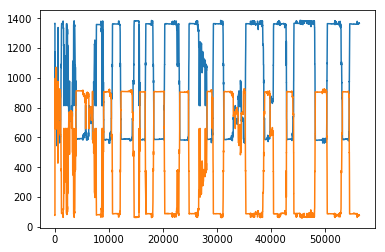

In [133]:
plt.plot(preprocess_position(pos))

##### Annotate videos

In [10]:
# No preprocessed data
def annotate(n, ax, pos, thresh=0.90):
    # Placeholder
    parts_visible = 0
    mean = np.array([0.0, 0.0])
    
    # Annotate head
    if pos[n, 3] > thresh:
        xy = np.array([pos[n, 1], pos[n, 2]])
        circle = plt.Circle(xy, radius=10, color='red')
        ax.add_artist(circle)
        mean += xy
        parts_visible += 1
    
    # Annotate tail
    if pos[n, 6] > thresh:
        xy = np.array([pos[n, 4], pos[n, 5]])
        circle = plt.Circle(xy, radius=10, color='blue')
        ax.add_artist(circle)
        mean += xy
        parts_visible += 1
        
    # Plot mean
    if parts_visible > 0:
        circle = plt.Circle(mean/parts_visible, radius=10, color='green')
        ax.add_artist(circle)

In [136]:
# Preprocessed data
def annotate(n, ax, pos, **kwargs):
    xy = np.array([pos[n, 0], pos[n, 1]])
    circle = plt.Circle(xy, radius=10, color='green')
    ax.add_artist(circle)

In [137]:
# Annotate settings
num_workers = 6
chunk_size = 60.0
frame_limit = 200

# Annotate each video
for video_file, pos_file in zip(video_filenames, pos_filenames):
    # Load csv data
    print('Loading position data in {}...'.format(pos_file))
    with open(pos_file, 'r') as f:
        reader = csv.reader(f)
        print('Column headers:')
        for i in range(3):
            text = next(reader, None)
            print(' '.join(text))
    pos = np.loadtxt(pos_file, skiprows=3, delimiter=',')
    print('Shape:', pos.shape)  
    
    # Smooth position data
    pos = preprocess_position(pos)
    
    # Annotate video
    print('Starting to annotate video in {}...'.format(video_file))
    vid = util.VideoAnnotator(video_file,
                              annotate_fn=annotate,
                              annotate_kwargs={'pos': pos, 'thresh': 0.9},
                              chunk_size=chunk_size,
                              output_filename=None,
                              output_resolution=[640, 360],
                              frame_limit=frame_limit)
    t = time.time()
    vid.run(max_workers=num_workers, verbose=False)
    print('Finished in {:.2f} seconds.\n'.format(time.time() - t))

Loading position data in /home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving/freely-moving-james-2019-10-03/evaluation-results/iteration-0/freely-movingOct3-trainset95shuffle1/R003_d44_2019-09-25-1437_vDeepCut_resnet50_freely-movingOct3shuffle1_1030000.csv...
Column headers:
scorer DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000
bodyparts head head head tail tail tail
coords x y likelihood x y likelihood
Shape: (56416, 7)
Starting to annotate video in /media/james/data/foraging/linear_track/raw/19-09-25/R003_d44_2019-09-25-1437_v.mp4...


Process 240.0-300.0 seconds:
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "../python/util.py", line 1234, in _process_chunk
    raise UserWarning('Some frames may be skipped in chunk {}.'.format(n))
Process 180.0-240.0 seconds:
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "../python/util.py", line 1234, in _process_chunk
    raise UserWarning('Some frames may be skipped in chunk {}.'.format(n))
Process 300.0-360.0 seconds:
Trace

Finished in 4664.25 seconds.

Loading position data in /home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving/freely-moving-james-2019-10-03/evaluation-results/iteration-0/freely-movingOct3-trainset95shuffle1/R002_d50_2019-10-03-1323_vDeepCut_resnet50_freely-movingOct3shuffle1_1030000.csv...
Column headers:
scorer DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000
bodyparts head head head tail tail tail
coords x y likelihood x y likelihood
Shape: (53537, 7)
Starting to annotate video in /media/james/data/foraging/linear_track/raw/19-10-03/R002_d50_2019-10-03-1323_v.mp4...


Process 240.0-300.0 seconds:
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "../python/util.py", line 1234, in _process_chunk
    raise UserWarning('Some frames may be skipped in chunk {}.'.format(n))
Process 300.0-360.0 seconds:
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "../python/util.py", line 1234, in _process_chunk
    raise UserWarning('Some frames may be skipped in chunk {}.'.format(n))
Process 360.0-420.0 seconds:
Trace

Finished in 4016.29 seconds.

Loading position data in /home/james/Documents/Projects/foraging/code/foraging-analysis/dlc/freely-moving/freely-moving-james-2019-10-03/evaluation-results/iteration-0/freely-movingOct3-trainset95shuffle1/R001_d59_2019-10-16-1140_vDeepCut_resnet50_freely-movingOct3shuffle1_1030000.csv...
Column headers:
scorer DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000 DeepCut_resnet50_freely-movingOct3shuffle1_1030000
bodyparts head head head tail tail tail
coords x y likelihood x y likelihood
Shape: (53300, 7)
Starting to annotate video in /media/james/data/foraging/linear_track/raw/19-10-16/R001_d59_2019-10-16-1140_v.mp4...


Process 0.0-60.0 seconds:
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "../python/util.py", line 1234, in _process_chunk
    raise UserWarning('Some frames may be skipped in chunk {}.'.format(n))
Process 60.0-120.0 seconds:
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/james/anaconda3/envs/dlc-ubuntu-GPU/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "../python/util.py", line 1234, in _process_chunk
    raise UserWarning('Some frames may be skipped in chunk {}.'.format(n))
Process 480.0-540.0 seconds:
Traceback

Finished in 3978.09 seconds.



## Video compression
The webcam videos may be recorded in 'MJPEG' format, which preserves quality at the expense of very large file sizes. We need to pull down videos from Google Drive, compress them locally, and re-upload the compressed version to the same Google Drive folder.

### Imports

In [1]:
# Numerical tools
import numpy as np
import math

# Plotting tools
import matplotlib.pyplot as plt

# OS tools
import os
from tempfile import TemporaryFile
import time
import subprocess as sp
import getpass

# Video tools
import moviepy
import moviepy.editor

# Custom modules
import sys
sys.path.insert(0, '../python/')
import util
import session
import plot
import analysis

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
mountainlab_pytools module not installed. Some functions from the ephys package may not be available.


### Load video file

In [33]:
import importlib
importlib.reload(util)

<module 'util' from '../python/util.py'>

In [34]:
service = util.GoogleDriveService()

In [20]:
folder_id = service.get_file_ids(filename='Projects',
                                 mime_type='application/vnd.google-apps.folder',
                                 exact_match=True)[0]

In [27]:
# Have to do this the hard way...
# https://stackoverflow.com/a/62655764
filepath = '/Projects/foraging/data/freely_moving/'
folders = [f for f in filepath.split('/') if len(f) > 0]

In [35]:
folder_ids = service.get_file_ids(mime_type='application/vnd.google-apps.folder',
                                  pageSize=1000)

In [ ]:
media_dir = '/media/james/data/foraging/linear_track/raw/19-10-03/' # where to download
base_filename = 'R002_d50_2019-10-03-1323'
cam_filename = base_filename + '_cam-1.mkv' # if comparing to behavior session
#cam_filename = base_filename + '.mkv' # if comparing videos

In [ ]:
# Allow read/write permissions from directory
password = getpass.getpass()
command = 'sudo -S chmod 777 %s' % media_dir # -S enables input from stdin
os.system('echo %s | %s' % (password, command));

In [ ]:
# Download video file
with open(media_dir + cam_filename, 'wb') as f:
    service.download(filename=cam_filename,
                     chunk_size=1024*1024*100,
                     file_object=f)

#### Preprocess video

In [ ]:
# Convert to mp4 format if not already
if not cam_filename.lower().endswith('.mp4'):
    new_filename = '.'.join(cam_filename.split('.')[:-1]) + '.mp4'
    cmd = ['ffmpeg',
           '-i', media_dir + cam_filename,
           '-codec', 'copy',
           '-copyts',
           '-vsync', 'vfr',
           media_dir + new_filename]
    cam_filename = new_filename
    with sp.Popen(cmd) as p:
        p.wait()

In [ ]:
# Get frame rate using ffprobe
cmd = ['ffprobe',
       '-i', media_dir + cam_filename,
       '-select_streams', 'v',
       '-show_streams',
       '-show_entries', 'stream=avg_frame_rate',
       '-of', 'csv=p=0']
with sp.Popen(cmd, bufsize=100, stdout=sp.PIPE, stderr=sp.PIPE) as p:
    p.wait() # waits until process has terminated
    s = p.stdout.read(100)
    fps = s.decode().split(',')[0].strip(' \n')
    fps = round(float(fps.split('/')[0]) / float(fps.split('/')[1]))
    
print(fps)

In [ ]:
# Get start time using ffprobe
cmd = ['ffprobe',
       '-i', media_dir + cam_filename,
       '-select_streams', 'v',
       '-show_entries', 'stream=start_time',
       '-of', 'csv=p=0']
with sp.Popen(cmd, bufsize=100, stdout=sp.PIPE, stderr=sp.PIPE) as p:
    p.wait() # waits until process has terminated
    s = p.stdout.read(100)
    t_start = float(s.decode().strip(' \n'))

In [ ]:
# Extract timestamps
# https://superuser.com/questions/841872/how-do-i-extract-the-timestamps-associated-with-frames-ffmpeg-extracts-from-a-vi
ts_filename = base_filename + '_ts.csv'
cmd = ['ffprobe',
       '-i', media_dir + cam_filename,
       '-select_streams', 'v',
       '-show_frames',
       '-show_entries', 'frame=pkt_pts_time',
       '-of', 'csv=p=0']
with open(media_dir+ts_filename, 'w') as f, \
     sp.Popen(cmd, stdout=f, stderr=sp.PIPE) as p:
    p.wait()

In [ ]:
# Load timestamps
ts = np.loadtxt(media_dir + ts_filename)
assert ts[0] == t_start
duration = ts[-1] - ts[0]

## Appendix

### Seeking in mkv files
File seeking in `mkv` (for instance, in the `VideoFileClip.get_frame` method) is unreliable for some reason. There could be a couple of explanations for this. The stack trace (top-down) for a seek call using the `-ss` flag is as follows:

Note how start time is added to the requested timestamp (value after `-ss`).
```c
static int open_input_file(OptionsContext *o, const char *filename
{
    ...
    timestamp = (o->start_time == AV_NOPTS_VALUE) ? 0 : o->start_time;
    /* add the stream start time */
    if (!o->seek_timestamp && ic->start_time != AV_NOPTS_VALUE)
        timestamp += ic->start_time;

    /* if seeking requested, we execute it */
    if (o->start_time != AV_NOPTS_VALUE) {
        int64_t seek_timestamp = timestamp;

        if (!(ic->iformat->flags & AVFMT_SEEK_TO_PTS)) {
            int dts_heuristic = 0;
            for (i=0; i<ic->nb_streams; i++) {
                const AVCodecParameters *par = ic->streams[i]->codecpar;
                if (par->video_delay) {
                    dts_heuristic = 1;
                    break;
                }
            }
            if (dts_heuristic) {
                seek_timestamp -= 3*AV_TIME_BASE / 23;
            }
        }
        ret = avformat_seek_file(ic, -1, INT64_MIN, seek_timestamp, seek_timestamp, 0);
        if (ret < 0) {
            av_log(NULL, AV_LOG_WARNING, "%s: could not seek to position %0.3f\n",
                   filename, (double)timestamp / AV_TIME_BASE);
        }
    }
    ...
}
``` 
[link](https://github.com/FFmpeg/FFmpeg/blob/master/fftools/ffmpeg_opt.c#L1160-1187)

Because we get the warning "could not seek to position", we know that `avformat_seek_file` must at some point return `-1`. This method attempts to call a `read_seek2` if the `AVFormatContext` (in this case `MatroskaDemuxContext`) has it; otherwise, it falls back on the original `read_seek` method.
```c
int avformat_seek_file(AVFormatContext *s, int stream_index, int64_t min_ts,
                       int64_t ts, int64_t max_ts, int flags)
{
    ...
    if (s->iformat->read_seek2) {
        ...
    }
    ...
    if (s->iformat->read_timestamp) {
        // try to seek via read_timestamp()
    }

    // Fall back on old API if new is not implemented but old is.
    // Note the old API has somewhat different semantics.
    if (s->iformat->read_seek || 1) {
        int dir = (ts - (uint64_t)min_ts > (uint64_t)max_ts - ts ? AVSEEK_FLAG_BACKWARD : 0);
        int ret = av_seek_frame(s, stream_index, ts, flags | dir);
        if (ret<0 && ts != min_ts && max_ts != ts) {
            ret = av_seek_frame(s, stream_index, dir ? max_ts : min_ts, flags | dir);
            if (ret >= 0)
                ret = av_seek_frame(s, stream_index, ts, flags | (dir^AVSEEK_FLAG_BACKWARD));
        }
        return ret;
    } 
    ...
}
```

As can be seen from the `MatroskaDemuxContext`, only a `read_seek` method is defined:
```c
AVInputFormat ff_matroska_demuxer = {
    .name           = "matroska,webm",
    .long_name      = NULL_IF_CONFIG_SMALL("Matroska / WebM"),
    .extensions     = "mkv,mk3d,mka,mks",
    .priv_data_size = sizeof(MatroskaDemuxContext),
    .read_probe     = matroska_probe,
    .read_header    = matroska_read_header,
    .read_packet    = matroska_read_packet,
    .read_close     = matroska_read_close,
    .read_seek      = matroska_read_seek,
    .mime_type      = "audio/webm,audio/x-matroska,video/webm,video/x-matroska"
};
```
[link](https://github.com/FFmpeg/FFmpeg/blob/master/libavformat/matroskadec.c#L4050)

So `read_seek` called from `avformat_seek_file` goes to (`av_seek_file`, which goes to `seek_frame_internal`, which calls) `matroska_read_seek`:
```c
static int matroska_read_seek(AVFormatContext *s, int stream_index,
                              int64_t timestamp, int flags)
{
    ...
    timestamp = FFMAX(timestamp, st->index_entries[0].timestamp);

    if ((index = av_index_search_timestamp(st, timestamp, flags)) < 0 || index == st->nb_index_entries - 1) {
        matroska_reset_status(matroska, 0, st->index_entries[st->nb_index_entries - 1].pos);
        while ((index = av_index_search_timestamp(st, timestamp, flags)) < 0 || index == st->nb_index_entries - 1) {
            matroska_clear_queue(matroska);
            if (matroska_parse_cluster(matroska) < 0)
                break;
        }
    }

    matroska_clear_queue(matroska);
    if (index < 0 || (matroska->cues_parsing_deferred < 0 && index == st->nb_index_entries - 1))
        goto err;

    tracks = matroska->tracks.elem;
    for (i = 0; i < matroska->tracks.nb_elem; i++) {
        tracks[i].audio.pkt_cnt        = 0;
        tracks[i].audio.sub_packet_cnt = 0;
        tracks[i].audio.buf_timecode   = AV_NOPTS_VALUE;
        tracks[i].end_timecode         = 0;
    }

    /* We seek to a level 1 element, so set the appropriate status. */
    matroska_reset_status(matroska, 0, st->index_entries[index].pos);
    if (flags & AVSEEK_FLAG_ANY) {
        st->skip_to_keyframe = 0;
        matroska->skip_to_timecode = timestamp;
    } else {
        st->skip_to_keyframe = 1;
        matroska->skip_to_timecode = st->index_entries[index].timestamp;
    }
    matroska->skip_to_keyframe = 1;
    matroska->done             = 0;
    ff_update_cur_dts(s, st, st->index_entries[index].timestamp);
    return 0;
err:
    // slightly hackish but allows proper fallback to
    // the generic seeking code.
    matroska_reset_status(matroska, 0, -1);
    matroska->resync_pos = -1;
    matroska_clear_queue(matroska);
    st->skip_to_keyframe =
    matroska->skip_to_keyframe = 0;
    matroska->done = 0;
    return -1;
}
```
[link](https://github.com/FFmpeg/FFmpeg/blob/master/libavformat/matroskadec.c#L3765-3811)

This function has to return `-1` at some point, which means that it must go to `err`. The `index` returned by `av_index_search_timestamp` comes from `ff_index_search_timestamp`, which performs a binary search of the time window:

```c
int ff_index_search_timestamp(const AVIndexEntry *entries, int nb_entries,
                              int64_t wanted_timestamp, int flags)
{
    int a, b, m;
    int64_t timestamp;

    a = -1;
    b = nb_entries;

    // Optimize appending index entries at the end.
    if (b && entries[b - 1].timestamp < wanted_timestamp)
        a = b - 1;

    while (b - a > 1) {
        m         = (a + b) >> 1;

        // Search for the next non-discarded packet.
        while ((entries[m].flags & AVINDEX_DISCARD_FRAME) && m < b && m < nb_entries - 1) {
            m++;
            if (m == b && entries[m].timestamp >= wanted_timestamp) {
                m = b - 1;
                break;
            }
        }

        timestamp = entries[m].timestamp;
        if (timestamp >= wanted_timestamp)
            b = m;
        if (timestamp <= wanted_timestamp)
            a = m;
    }
    m = (flags & AVSEEK_FLAG_BACKWARD) ? a : b;

    if (!(flags & AVSEEK_FLAG_ANY))
        while (m >= 0 && m < nb_entries &&
               !(entries[m].flags & AVINDEX_KEYFRAME))
            m += (flags & AVSEEK_FLAG_BACKWARD) ? -1 : 1;

    if (m == nb_entries)
        return -1;
    return m;
}
```
[link](https://github.com/FFmpeg/FFmpeg/blob/master/libavformat/utils.c#L2053-2094)


This could be resulting in `index = -1` and leading us to `err`. However, we also get the following warning in the `ffmpeg` output:

```shell
[matroska,webm @ 0x19cd9e0] Invalid EBML number size tag 0x01 at pos 782 (0x30e)
```

Note the call to `matroska_parse_cluster` in `matroska_read_seek`; particularly, if it returns `-1`, this could also lead to `err`. `matroska_parse_cluster` calls `ebml_parse`([link](https://github.com/FFmpeg/FFmpeg/blob/master/libavformat/matroskadec.c#L1163)), which, depending on the version of `ffmpeg`, can lead to the warning shown above.

So in conclusion, the issue with seeking in matroska files is probably due to one of two things: either a problem with reformatting timestamps in the `read_seek` code block instead of `read_seek2`, or a problem parsing EBML numbers for some frames (why, I'm not sure). In any case, remuxing (but *not* transcoding) to `mp4` seems to fix the seeking issues:

```shell
ffmpeg -i <filename>.mkv -codec copy -copyts -vsync vfr <filename>.mp4
```

The `-copyts` flag is important; otherwise, `pts` will be re-encoded from zero in the new file. Additionally, setting `-vsync` to `vfr` allows frames to pass through with their timestamps rather than being duplicated or dropped to maintain a constant frame rate (`cfr`). Although this doesn't appear to make a difference on videos re-muxed so far, the `mp4` demuxer defaults to `cfr`, whereas the `mkv` muxer defaults to `vfr`, so it's probably worth specifying `vfr` just to be safe. The internal frame rate (`r_frame_rate`) may increase to better match timestamps, but this won't affect the actual number of frames. (see [here](https://superuser.com/questions/602950/problems-with-frame-rate-on-video-conversion-using-ffmpeg-with-libx264) or [here](https://video.stackexchange.com/questions/20789/ffmpeg-default-output-frame-rate) for more details) The `pts` may change as well, but that is due to a change in `time_base`; `pkt_pts_time` and `pkt_dts_time` should remain the same, since `pkt_pts` = `time_base` * `pkt_pts_time`.

In [ ]:
pts_audio = np.loadtxt('/media/james/data/foraging/linear_track/raw/19-10-03/pts_audio.txt')
pts_video = np.loadtxt('/media/james/data/foraging/linear_track/raw/19-10-03/pts_video.txt')

In [ ]:
plt.plot(np.arange(len(pts_audio))[:500]/len(pts_audio), pts_audio[:500])
plt.plot(np.arange(len(pts_video))[:500]/len(pts_video), pts_video[:500])

In [ ]:
import scipy
pts_audio_interp = scipy.interpolate.interp1d(np.arange(len(pts_audio))/len(pts_audio), pts_audio)
pts_video_interp = scipy.interpolate.interp1d(np.arange(len(pts_video))/len(pts_video), pts_video)

In [ ]:
tt = np.linspace(0.0, 0.99, 10000)
plt.plot(pts_video_interp(tt) - pts_audio_interp(tt))

In [ ]:
from scipy.io import wavfile

audio_filename = '/media/james/data/foraging/linear_track/raw/19-10-03/audio.wav'
fs, data = wavfile.read(audio_filename)

In [ ]:
plt.plot(data/2**15)